1. Предобработка

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [225]:
data = pd.read_csv('data/anon_gps_tracks_with_dive.csv')
data.head(3)

,Unnamed: 0,lat,lon,alt,unix,bird,species,year,date_time,max_depth.m,colony2,coverage_ratio,is_dive,is_dive_1m,is_dive_2m,is_dive_4m,is_dive_5m,is_dive_0m
0,1,56.095451,-6.233089,-23.059999,1340627854,1,tCOGU,t2012,2012-06-25 13:37:34,-2.172046,1,0.5,False,False,False,False,False,False
1,2,56.095408,-6.233520,-2.983077,1340627954,1,tCOGU,t2012,2012-06-25 13:39:14,-1.152306,1,0.6,False,False,False,False,False,False
2,3,56.095437,-6.234275,3.470286,1340628054,1,tCOGU,t2012,2012-06-25 13:40:54,-2.172046,1,0.7,False,False,False,False,False,False


In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263718 entries, 0 to 263717
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      263718 non-null  int64  
 1   lat             263718 non-null  float64
 2   lon             263718 non-null  float64
 3   alt             263718 non-null  float64
 4   unix            263718 non-null  int64  
 5   bird            263718 non-null  int64  
 6   species         263718 non-null  object 
 7   year            263718 non-null  object 
 8   date_time       263718 non-null  object 
 9   max_depth.m     263718 non-null  float64
 10  colony2         263718 non-null  int64  
 11  coverage_ratio  262648 non-null  float64
 12  is_dive         263718 non-null  bool   
 13  is_dive_1m      263718 non-null  bool   
 14  is_dive_2m      263718 non-null  bool   
 15  is_dive_4m      263718 non-null  bool   
 16  is_dive_5m      263718 non-null  bool   
 17  is_dive_0m

In [227]:
data.describe()

,Unnamed: 0,lat,lon,alt,unix,bird,max_depth.m,colony2,coverage_ratio
count,263718.000000,263718.000000,263718.000000,263718.000000,2.637180e+05,263718.000000,263718.000000,263718.000000,262648.000000
mean,131859.500000,56.580051,-4.234669,23.743436,1.359405e+09,53.508103,2.031185,4.063989,0.569349
std,76128.973483,2.476717,1.854708,249.990511,2.821933e+07,32.627900,13.735655,3.111499,0.349948
min,1.000000,51.468828,-6.749091,-482.654556,1.306926e+09,1.000000,-10.329966,1.000000,0.000000
25%,65930.250000,56.088568,-6.230647,-0.129882,1.339011e+09,25.000000,-1.407241,1.000000,0.200000
50%,131859.500000,56.255339,-5.301294,8.889465,1.368729e+09,49.000000,-0.581252,2.000000,0.800000
75%,197788.750000,58.691067,-2.664804,25.936559,1.372852e+09,83.000000,0.887174,6.000000,0.900000
max,263718.000000,59.824936,-1.042002,9839.139371,1.404837e+09,108.000000,250.468539,10.000000,1.100000


Что имеем отсюда:

1. Записей об уникальных птицах не очень много (108 птиц)

2. Колоний птиц еще меньше (10 колоний)

3. Значения `coverage_ratio` могут быть > 1, к тому же столбец содержит пропуски (NA). Что значит этот столбец, как его можно будет использовать? Удалим за ненадобностью

4. Столбец `date_time` повторяет информацию из `unix`, удалим его

5. Столбец `year` повторяет информацию из столбца `date_time`, удалим его

In [228]:
data.drop(columns=['coverage_ratio', 'date_time', 'year'], inplace=True)

Как ведет себя столбец `max_depth.m` (максимальное погружение в 100-секундном интервале) у одной и той же птицы с течением времени?

<AxesSubplot:>

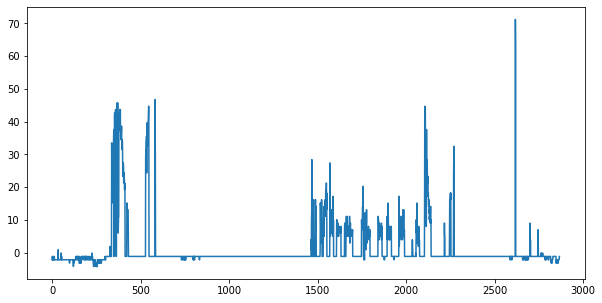

In [229]:
data[data.bird == 1].sort_values(by='unix')['max_depth.m'].plot(figsize=(10,5))

Интересные провалы до нуля в районах 500-1500 и 2300-2600. С чем это могло быть связано?

Существует ли время, когда замеры по птице №1 не проводились?

<AxesSubplot:>

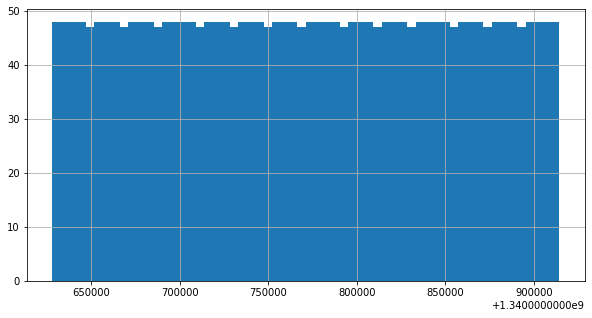

In [230]:
data[data.bird == 1].sort_values(by='unix').unix.hist(figsize=(10,5), bins=60)

Распределение времени записей о птице №1 на гистограмме выглядит равномерным, значит графику выше про максимальное погружение в окне можно верить, он не имеет пропусков.

Построим гистограмму расстояния - местоположения птиц от центра колонии, для этого добавим колонку dist3d и построим гистограмму расстояний для первой колонии.

In [231]:
def dist3d(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    dLon = np.deg2rad(lon2 - lon1)

    cosd = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(dLon)
    Earth_radius_km = 6371
    return Earth_radius_km * np.arccos(cosd)

<AxesSubplot:>

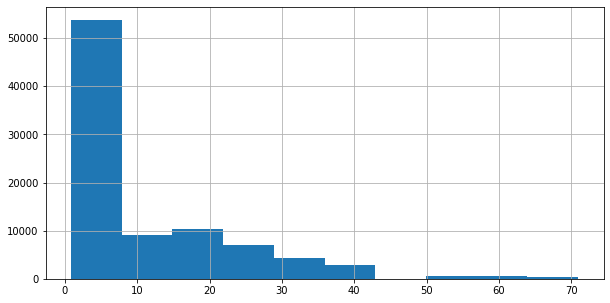

In [232]:
clat = [data[data.colony2 == i].lat.mean() for i in data.colony2.unique()]
clon = [data[data.colony2 == i].lon.mean() for i in data.colony2.unique()]

data = data.assign(dist3d = [
    dist3d(lat, lon, clat[int(c) - 1], clon[int(c) - 1])
        for (lat, lon, c) in data[['lat', 'lon', 'colony2']].values])

data[data.colony2 == 1].dist3d.hist(figsize=(10,5)) # первая колония

Построим 2d-гистограмму маршрута птицы №1 (которая, как мы могли видеть по таблице, принадлежит первой колонии).

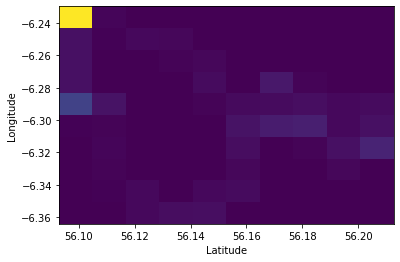

In [233]:
plt.hist2d(data[data.bird == 1].lat, data[data.bird == 1].lon)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Данная гистограмма описывает пройденный птицей маршрут. Latitude - угол от экватора, longitude - угол от нулевого меридиана. Судя по отчетливой "петле" на картинке, птица после перелета возвращалась в свою колонию, где проводила большую часть времени.

Подтверждаем scatter'ом.

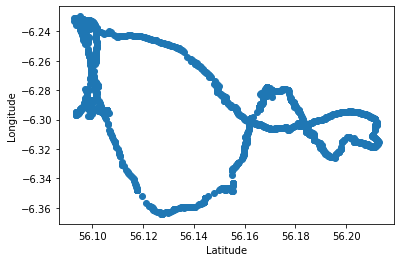

In [234]:
plt.scatter(data[data.bird == 1].lat, data[data.bird == 1].lon)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Теперь построим гистограмму по dist3d для птицы №1.

<AxesSubplot:>

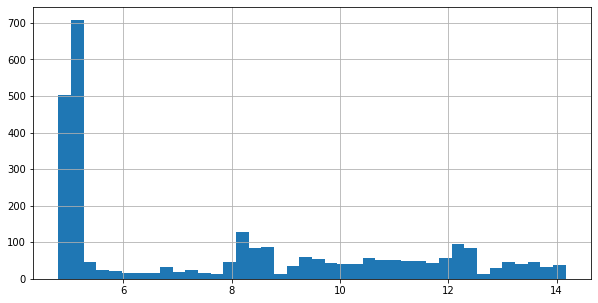

In [235]:
data[data.bird == 1].dist3d.hist(figsize=(10,5), bins=40)

Как видим, птица часто была в районе 2-3 километров от предполагаемого центра ее колонии, а также отлетала от нее на расстояние до 14 километров.

Проблема в том, что записи о местоположении птиц в какой-либо колонии могут быть плохо интепретированы из-за возможной перелетности птиц. Посмотрим, в какие месяцы велось наблюдение за птицами.

<AxesSubplot:>

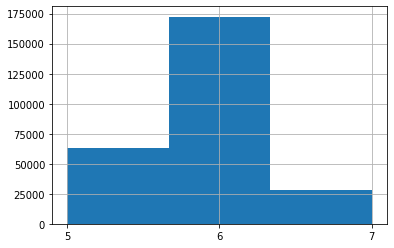

In [236]:
from datetime import datetime

def g(ts):
    return datetime.utcfromtimestamp(ts).strftime('%m')[1:]

data['unix'].apply(g).sort_values().hist(bins=3)

Посмотрим, как зависит от месяца местоположение птиц.

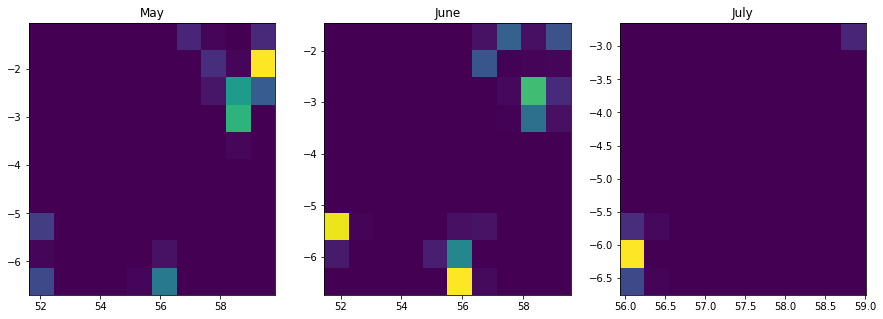

In [237]:
d2 = data.assign(month = data['unix'].apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%m')[1:]))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist2d(d2[d2.month == '5'].lat, d2[d2.month == '5'].lon)
axes[0].set_title("May")
axes[1].hist2d(d2[d2.month == '6'].lat, d2[d2.month == '6'].lon)
axes[1].set_title("June")
axes[2].hist2d(d2[d2.month == '7'].lat, d2[d2.month == '7'].lon)
axes[2].set_title("July")
plt.show()

Насколько варьируются координаты птиц в каждой колонии?

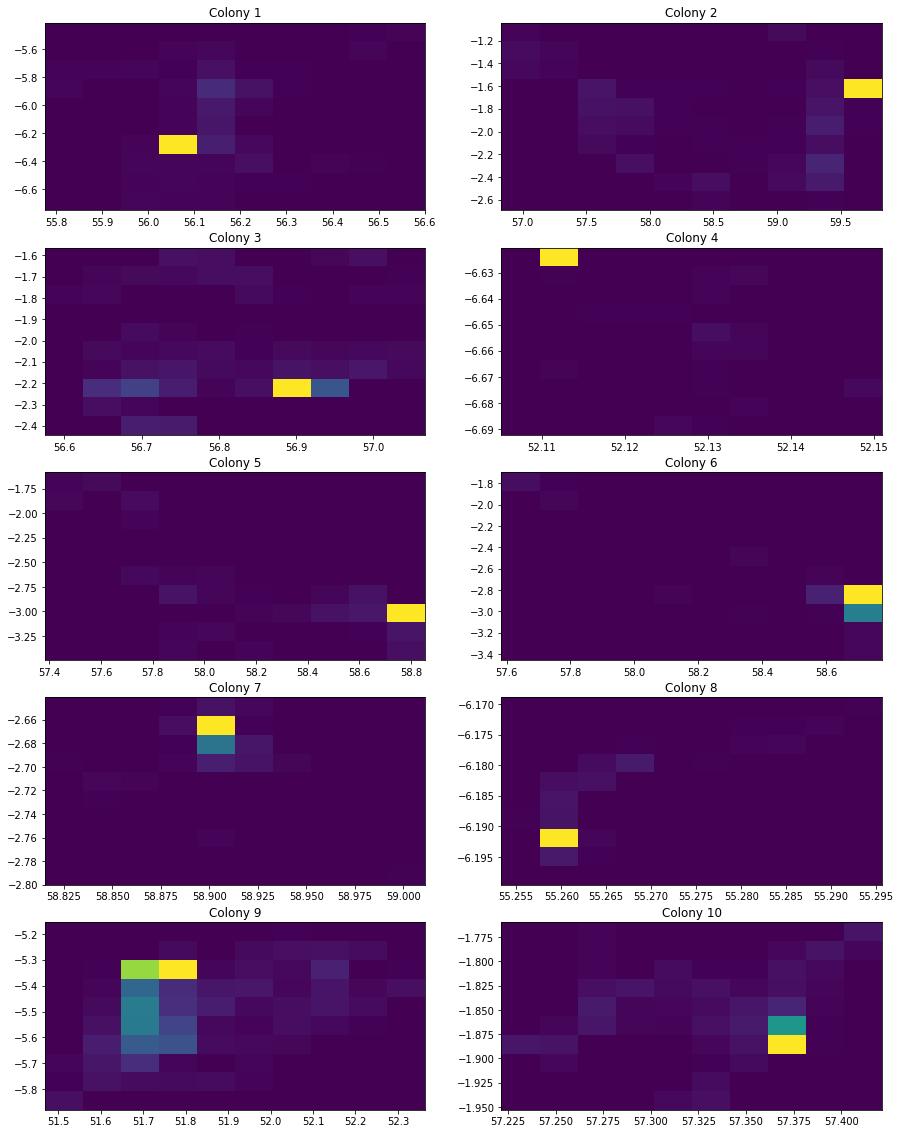

In [238]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
for i in range(0, 10):
    axes[i // 2][i % 2].hist2d(d2[d2.colony2 == i + 1].lat, d2[d2.colony2 == i + 1].lon)
    axes[i // 2][i % 2].set_title("Colony {}".format(i + 1))
plt.show()

Разброс координат (широты и долготы) в каждой колонии не очень большой - значит усреднять их для определения центра колонии можно (ну, и птицы не перелетали в момент ведения записей).

Создадим столбец `dive_depth` для более точного определения глубины погружения.

<AxesSubplot:>

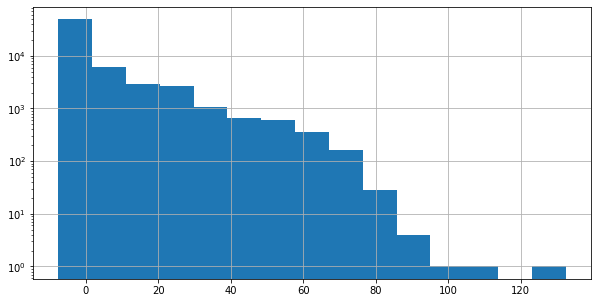

In [239]:
def dive_depth(m0, m1, m2, m4, m5, mmax):
    if m5:
        return max(5, mmax)
    elif m4:
        return max(4, mmax) if mmax < 5 else 4
    elif m2:
        return max(2, mmax) if mmax < 4 else 2
    elif m1:
        return max(1, mmax) if mmax < 2 else 1
    else:
        return mmax

data = data.assign(dive_depth = [
    dive_depth(*row) for row in data[[
        'is_dive_0m', 'is_dive_1m', 'is_dive_2m', 'is_dive_4m', 'is_dive_5m', 'max_depth.m']].values])

data[data.species == "tCOGU"].dive_depth.hist(figsize=(10,5), log=True, bins=15) # птичка COGU

Гипотеза 1: распределение глубины погружения птиц гильемо/кайра подчиняется экспоненциальному закону.

<AxesSubplot:>

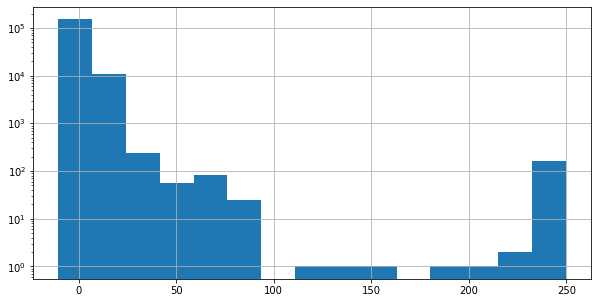

In [240]:
data[data.species == "tRAZO"].dive_depth.hist(figsize=(10,5), log=True, bins=15) # птичка RAZO

(Вообще странно, так как гагарки глубже 10 метров обычно не заплывают, а рекордом является 70 метров)

<AxesSubplot:>

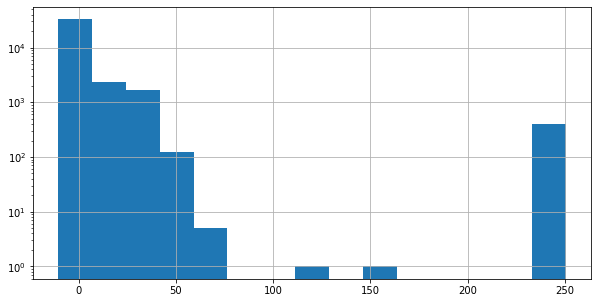

In [241]:
data[data.species == "tEUSH"].dive_depth.hist(figsize=(10,5), log=True, bins=15) # птичка EUSH

По данным Википедии, хохлатые бакланы ныряют на глубину до 45 метров. Здесь же мы наблюдаем выбросы.

Гипотеза 2: данные содержат очень большую глубину погружения из-за потери датчиков TDR или гибели птицы. Одинаковая глубина в ~250 метров может быть связана с одновременной гибелью гагарок и бакланов в одном месте.

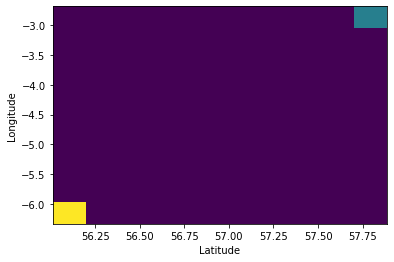

In [242]:
plt.hist2d(data[data.dive_depth > 150].lat, data[data.dive_depth > 150].lon)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Гистограмма выше косвенно подтверждает гипотезу.

Профильтрованные данные

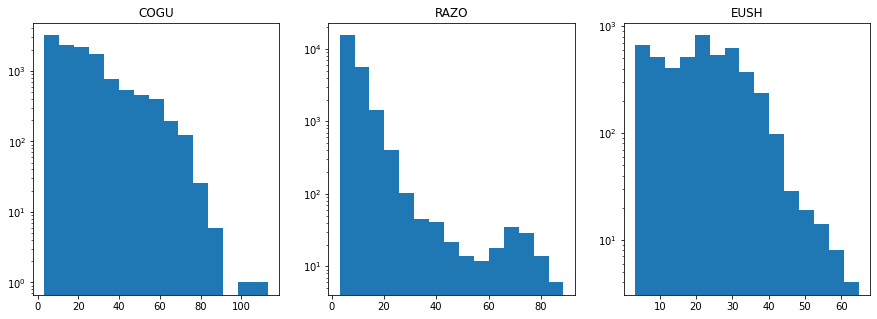

In [243]:
d = data[(data.dive_depth < 120) & (data.is_dive)] # профильтруем предположительно мертвых птиц

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(d[(d.species == "tCOGU")].dive_depth, log=True, bins=15)
axes[0].set_title("COGU")
axes[1].hist(d[(d.species == "tRAZO")].dive_depth, log=True, bins=15)
axes[1].set_title("RAZO")
axes[2].hist(d[(d.species == "tEUSH")].dive_depth, log=True, bins=15)
axes[2].set_title("EUSH")
plt.show()

Насколько птицы определенного вида "любят" заплывать на большую глубину? 

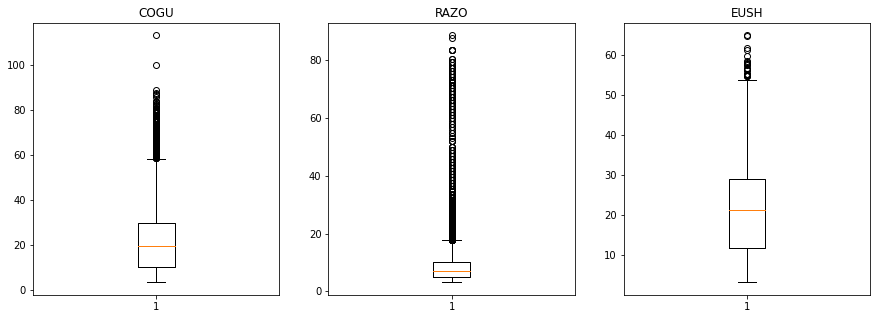

In [244]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].boxplot(d[(d.species == "tCOGU")]['dive_depth'])
axes[0].set_title("COGU")
axes[1].boxplot(d[(d.species == "tRAZO")]['dive_depth'])
axes[1].set_title("RAZO")
axes[2].boxplot(d[(d.species == "tEUSH")]['dive_depth'])
axes[2].set_title("EUSH")
plt.show()

По имеющимся данным по фану можно построить график расстояния птицы от ее колонии.

<AxesSubplot:>

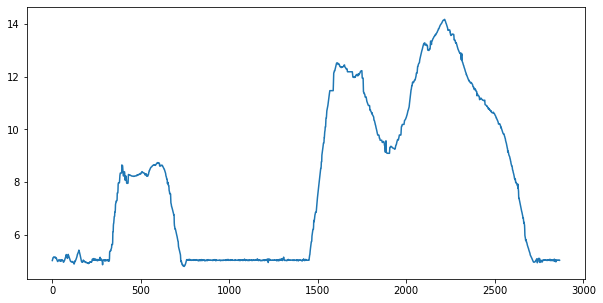

In [245]:
data[data.bird == 1]['dist3d'].plot(figsize=(10,5))

Затем найти скорость ее приближения/удаления от колонии (горизонтальная скорость)

<AxesSubplot:>

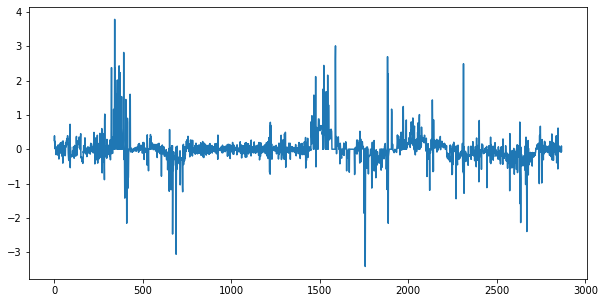

In [ ]:
data[data.bird == 1]['dist3d'].diff(1).apply(lambda a: a / 100. * 1000).plot(figsize=(10,5))
# diff - to take delta
# / 100 to get speed (delta km / sec)
# * 1000 to get m/s
# получили скорость приближения-удаления от колонии

Таким же образом можно найти скорость изменения высоты в географических координатах (вертикальная скорость)

<AxesSubplot:>

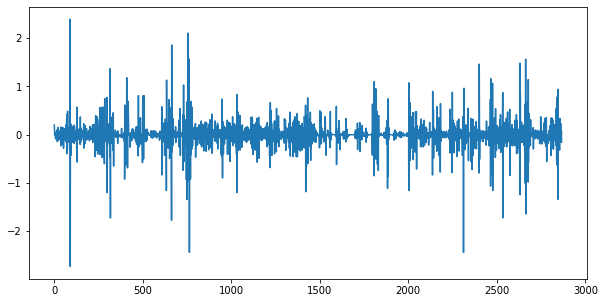

In [ ]:
data[data.bird == 1]['alt'].diff(1).apply(lambda a: a / 100.).plot(figsize=(10,5))

Совмещая пару последних полученных данных можно по векторам средних скоростей узнать среднюю скорость полета птицы в пространстве

count    2867.000000
mean        0.270544
std         0.356802
min         0.000000
25%         0.075990
50%         0.171962
75%         0.316525
max         3.781803
dtype: float64


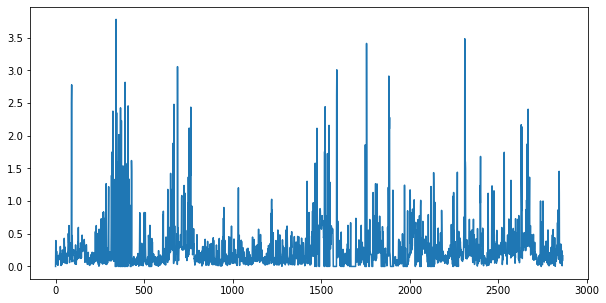

In [246]:
horiz = data[data.bird == 1]['dist3d'].diff(1).apply(lambda a: a / 100. * 1000).fillna(0)
vert = data[data.bird == 1]['alt'].diff(1).apply(lambda a: a / 100.).fillna(0)

print(np.hypot(horiz, vert).describe())

plt.figure(figsize=(10, 5))
plt.plot(np.hypot(horiz, vert))
plt.show()

Сохраним датасет.

In [ ]:
data.to_csv('./data/processed.csv')